In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import Trainer

In [3]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [3]:
model_name = "layoutlm"
dataset_name = "funsd"

In [4]:
logging.basicConfig(filename='logs/layoutlm_funsd.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [5]:
dataset = load_dataset("nielsr/funsd")

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 50
    })
})

In [7]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)
n_classes

7

In [8]:
train_dataset = ImageLayoutDataset(dataset['train'])

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:01<00:00, 121.99it/s]


In [9]:
validation_dataset = ImageLayoutDataset(dataset['test'])

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 102.48it/s]


In [10]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle = True
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = True
)

## Importing model

In [13]:
device = "cuda"

In [44]:
layoutlm = LayoutLMForTokenClassification.from_pretrained('microsoft/layoutlm-base-uncased', num_labels = n_classes)
layoutlm.to(device)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
 

In [15]:
print(f'''
    Model Info
    -----------------
    
    Treinable params: {sum(p.numel() for p in layoutlm.parameters() if p.requires_grad)}
    Non Treinable params: {sum(p.numel() for p in layoutlm.parameters() if not p.requires_grad)}

''')


    Model Info
    -----------------
    
    Treinable params: 112633351
    Non Treinable params: 0




In [45]:
trainer = Trainer(layoutlm,
                  model_type="layoutlm")

In [46]:
trainer.compile(
    train_dataloader,
    validation_dataloader,
    n_classes= n_classes,
    device = "cuda"
)

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:20<00:47,  6.73s/it]

Early stopping on epoch 3


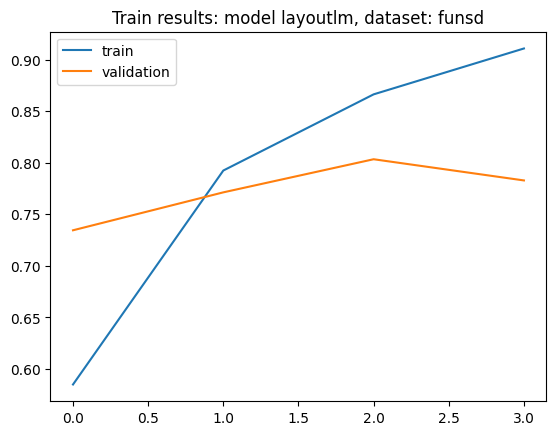

In [47]:
plt.plot(trainer.history['train-f1'],
         label = "train")
plt.plot(trainer.history['validation-f1'],
         label = "validation")

plt.title(f"Train results: model {model_name}, dataset: {dataset_name}")

plt.legend()

In [48]:
trainer.history['validation-f1']

[0.7345318794250488,
 0.7713051438331604,
 0.8034088611602783,
 0.7828624844551086]

In [49]:
trainer.history['train-f1']

[0.5850274562835693,
 0.7924684286117554,
 0.8663224577903748,
 0.9108020663261414]